In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import math
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error


# Reading Images and preparing the dataset

please put your images folder that contain all the images in the project folder

Source image in gray


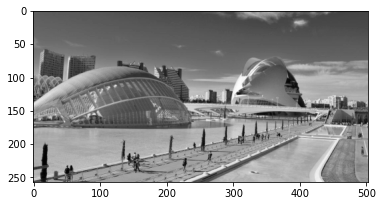

In [2]:
img_number = '02'#image number ex:01,08,10,22,30,09
#reading images
img = cv2.imread('images/p0'+img_number+', a_source.png')
target_img = cv2.imread('images/p0'+img_number+', b_target.png')
groundTruth_img = cv2.imread('images/p0'+img_number+', c_groundtruth.png') 

#resize source image for faster results if needed
size = 1
img = cv2.resize(img, (0,0), fx=size, fy=size) 
#we can uncomment these for faster performence when we make our size smaller
#target_img = cv2.resize(target_img, (0,0), fx=size, fy=size)
#groundTruth_img = cv2.resize(groundTruth_img, (0,0), fx=size, fy=size)

#converting source image to greyscale
source_gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
m,n = source_gray_img.shape#width,height of source image
print("Source image in gray")
plt.imshow(source_gray_img, cmap='gray')
plt.show()

Target Image:


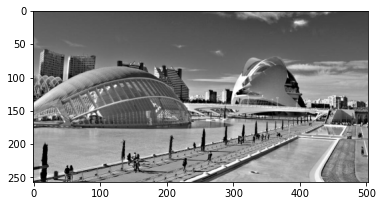

(257, 503)


In [3]:
#converting target image to greyscale because the orginial target image has 3 channels of RGB
print("Target Image:")
plt.imshow(target_img, cmap='gray')
plt.show()
target_img = cv2.cvtColor(target_img,cv2.COLOR_BGR2GRAY)
w,h = target_img.shape#width,height of target image
print(target_img.shape)


In [4]:
source_gray_img.shape, target_img.shape

((257, 503), (257, 503))

# Extracting features for source gray image

In [5]:
#WxW widnow size of neighbour pixels is: "window_size+window_size+1"
#so 4 means our super pixel size is 9x9
window_size = 4
p = (window_size + window_size + 1)**2
p

81

In [6]:
#We take every pixel in our image and find the WxW neighbours where (i,j) pixel is in the center 
#(X,Y) nested loops find the surrounded pixels for pixle(i,j)
#we return a 3d array where every (i,j) pixel has a 3rd dimension array that includes all the neighbour pixels
#example features_vector[500][500][25] where 81 is P size and [500][500] is image size
def extract_vectorfeatures(img):
    m,n = img.shape
    vector_features = np.zeros((m,n,p)) 
    for i in range(window_size,m-window_size):
        for j in range(window_size,n-window_size):
            k = 0
            vector_features[i][j][k] = int(img[i,j])
            for x in range(1,window_size):
                for y in range(1,window_size):
                    k += 1
                    if(x != 0 or y != 0):
                        vector_features[i][j][k] = int(img[i+x,j+y])
                        vector_features[i][j][k] = int(img[i-x,j+y])
                        vector_features[i][j][k] = int(img[i-x,j-y])
                        vector_features[i][j][k] = int(img[i+x,j-y])
            for x in range(1,window_size):
                    k += 1
                    vector_features[i][j][k] = int(img[i+x,j])
                    vector_features[i][j][k] = int(img[i-x,j])
                    vector_features[i][j][k] = int(img[i,j+x])
                    vector_features[i][j][k] = int(img[i,j-x])
    return vector_features

In [7]:
#extracting other features from our features_vector that we created above
def mean(features):
    return features.mean(axis=1)    
def varriance(features):
    return features.var(axis=1)

#to find the edges first we need to remove the noise, so we blur our image
# then using sobel derivatives where a small shift of gradient returns a white pixel indicating an 
# vh is for Horizontal changes
# vv si for Vertical changes
#we can compine them to get a full image
#refrence  :https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html

def edges(img):
    blured = cv2.GaussianBlur(img, (0, 0), 0.2)
    vh = cv2.Sobel(blured, -1, 1, 0)
    vv = cv2.Sobel(blured, -1, 0, 1)
    v = 0.5*vv + 0.5*vh
    return v

In [8]:
#get the features_vector of the source greyscale image and reshape it to 2D
source_vectorfeatures = extract_vectorfeatures(source_gray_img)
source_vectorfeatures = source_vectorfeatures.reshape(-1,p)
source_vectorfeatures.shape

(129271, 81)

In [9]:
#return the grey channel values as features 
X = np.reshape(source_gray_img, source_gray_img.shape)

#split our colored image to get seperate BGR labels to train the model
B, G, R = cv2.split(img)

#reshape our vectors to 1D channels width*height
X = np.reshape(X,m*n)
B = np.reshape(B,m*n)
G = np.reshape(G,m*n)
R = np.reshape(R,m*n)

R.shape,B.shape,G.shape,X.shape

((129271,), (129271,), (129271,), (129271,))

Now we use the functions to extract features and demonstrate the output images
1. Mean
2. Varriance
3. Edges

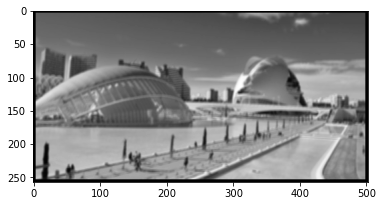

(129271,)

In [10]:
mean_features = mean(source_vectorfeatures)
tempimg = np.reshape(mean_features,(m,n))
mean1 = tempimg
plt.imshow(tempimg, cmap='gray')
plt.show()
mean_features.shape

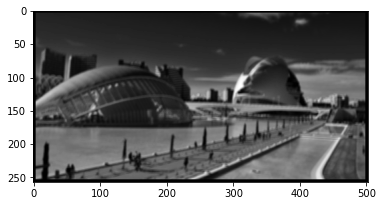

(129271,)

In [11]:
var_features = varriance(source_vectorfeatures)
tempimg = np.reshape(var_features,(m,n))
plt.imshow(tempimg, cmap='gray')
plt.show()
var_features.shape

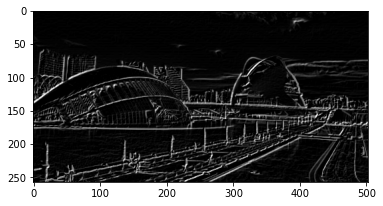

In [12]:
edges_features = edges(source_gray_img)
plt.imshow(edges_features, cmap='gray')
plt.show()
edges_features = np.reshape(edges_features,m*n)

In [13]:
#stack all features together
X = np.column_stack((X,var_features,mean_features,edges_features))

In [14]:
#preprocessing our data
scaler = StandardScaler()
scaler.fit(X)
X =  scaler.transform(X)

In [15]:
X.shape

(129271, 4)

# Extracting features for Target image

Here will do the exact same process above but for our target image

In [16]:
target_vectorfeatures = extract_vectorfeatures(target_img)
target_vectorfeatures = target_vectorfeatures.reshape(-1,p)

In [17]:
X_test = np.reshape(target_img, target_img.shape)
X_test = np.reshape(X_test,w*h)

In [18]:
var_features = varriance(target_vectorfeatures)

In [19]:
mean_features = mean(target_vectorfeatures)

In [20]:
edges_features = edges(target_img)
edgesimg=edges_features
edges_features = np.reshape(edges_features,w*h)

In [21]:
X_test = np.column_stack((X_test,var_features,mean_features,edges_features))

In [22]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test =  scaler.transform(X_test)

# trainging our model we Used KNN classifier as  a model

In [23]:
X_test.shape,X.shape

((129271, 4), (129271, 4))

In [24]:
#here we create 3 different model for B,G,R channels 
#Using knn classifier where every model is for a different 
#BGR channel

model1 = KNeighborsClassifier(n_neighbors=3)
model2 = KNeighborsClassifier(n_neighbors=3)
model3 = KNeighborsClassifier(n_neighbors=3)

model1.fit(X,B)
model2.fit(X,G)
model3.fit(X,R)
    
yhat_B= model1.predict(X_test)
yhat_G= model2.predict(X_test)
yhat_R= model3.predict(X_test)


predicted image


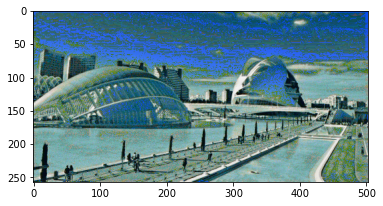

Ground truth image


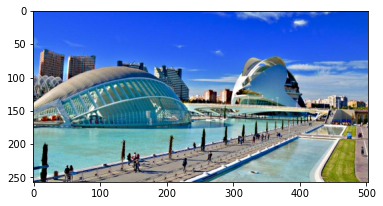

In [25]:
#we reshape all the channels to the original image width x height
yhat_B = np.reshape(yhat_B,(w,h))
yhat_G = np.reshape(yhat_G,(w,h))
yhat_R = np.reshape(yhat_R,(w,h))

#we merge the channels together to form an BGR image
predicted_img = cv2.merge((yhat_B,yhat_G,yhat_R))
predicted_img = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2RGB)#conver from BGR to RGB
print("predicted image")
plt.imshow(predicted_img)
plt.show()

groundTruth_img  = cv2.cvtColor(groundTruth_img, cv2.COLOR_BGR2RGB)
print("Ground truth image")
plt.imshow(groundTruth_img)
plt.show()

In [28]:
def mae(y_true, y_pred):
    mae = np.sum(np.absolute((y_true.astype("float") - y_pred.astype("float"))))
    mae /= float(y_true.shape[0] * y_pred.shape[1])
    return mae / 3.0

In [29]:
print("MAE is : ",mae(groundTruth_img,predicted_img))

MAE is :  25.75054472129609


In [30]:
#this is the same as the function above
differenceRGB  = (groundTruth_img.astype("float") - predicted_img.astype("float"))
absoluteRGB = np.absolute(differenceRGB)
AverageRGB = np.sum(absoluteRGB , axis = 2) / 3.0
MAE = np.sum(AverageRGB) / float(groundTruth_img.shape[0] * predicted_img.shape[1]) #sum of pixels / num of pixels
MAE

25.75054472129609